In [2]:
# A check to see if environment variables are setup correctly:
import sys, math, random, ROOT, uproot, torch
import numpy as np

In [3]:
# now do stuff:
signal_file = ROOT.TFile("formatted/tau_signal.root")
signal_tree = signal_file.Get("signal")

background_file = ROOT.TFile("formatted/background.root")
background_tree = background_file.Get("background")

signal_entries = signal_tree.GetEntries()
background_entries = background_tree.GetEntries()
print(signal_entries)
print(background_entries)
#signal_tree.Print()

7812
69049


In [4]:
signal_layer_ets = []
background_layer_ets = []
all_layer_ets = []
all_truth = []

for i in range(signal_entries):
    signal_tree.GetEntry(i)
    layer_ets = [signal_tree.L0EM, signal_tree.L1EM, signal_tree.L2EM, signal_tree.L3EM, signal_tree.LHAD]
    layer_ets = [et / 1000. for et in layer_ets]
    
    signal_layer_ets.append(layer_ets)
    all_layer_ets.append(layer_ets)
    
    all_truth.append(1)
    
    
for i in range(background_entries):
    background_tree.GetEntry(i)
    layer_ets = [background_tree.L0EM, background_tree.L1EM, background_tree.L2EM, background_tree.L3EM, background_tree.LHAD]
    layer_ets = [et / 1000. for et in layer_ets]
    
    background_layer_ets.append(layer_ets)
    all_layer_ets.append(layer_ets)
    
    all_truth.append(0)

In [5]:
# Create a histogram of reconstructed Et of all signal and background events
h_signal = ROOT.TH1F("signal_recoEt", "signal_recoEt", 100, -20, 100)
h_signal.GetXaxis().SetTitle("Reconstructed Et")
h_signal.GetYaxis().SetTitle("Events")

h_background = ROOT.TH1F("background_recoEt", "background_recoEt", 100, -20, 100)
h_background.GetXaxis().SetTitle("Reconstructed Et")
h_background.GetYaxis().SetTitle("Events")

c = ROOT.TCanvas("c", "canvas", 400, 400)

In [6]:
h_signal.Reset()
for event in signal_layer_ets:
    h_signal.Fill(sum(event))
print(h_signal.GetEntries())
    
h_background.Reset()
for event in background_layer_ets:
    h_background.Fill(sum(event))
print(h_background.GetEntries())

7812.0
69049.0


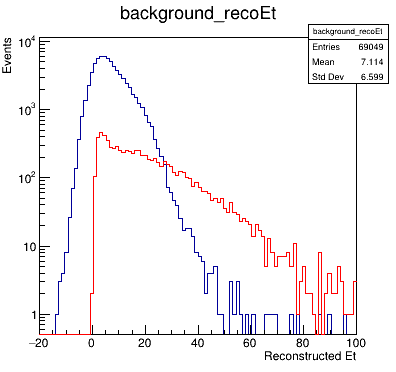

In [9]:
h_background.Draw()
h_signal.Draw('same')
h_signal.SetLineColor(2)
c.SetLogy()
c.Draw()

In [44]:
# Create data for initial ROC curves
signal_roc_counts = np.zeros(100)
background_roc_counts = np.zeros(100)

signal_roc_counts[0] += 1

for i, layers in enumerate(all_layer_ets):
    total_et = sum(layers)
    if i == 0:
        print(total_et)
    
    for j in range(100):
        if total_et > (-20 + j*1.5):
            if all_truth[i] == 1:
                signal_roc_counts[j] += 1
            elif all_truth[i] == 0:
                background_roc_counts[j] += 1
            
# Convert event counts to efficiencies
signal_roc_eff = np.array([float(sig_count / signal_roc_counts[0]) for sig_count in signal_roc_counts])
background_roc_eff = np.array([float(back_count / background_roc_counts[0]) for back_count in background_roc_counts])

#signal_roc_eff = list(signal_roc_eff)
#background_roc_eff = list(background_roc_eff)

#print(signal_roc_counts)
#print(signal_roc_eff)
#print(background_roc_counts)
#print(background_roc_eff)

22.5625


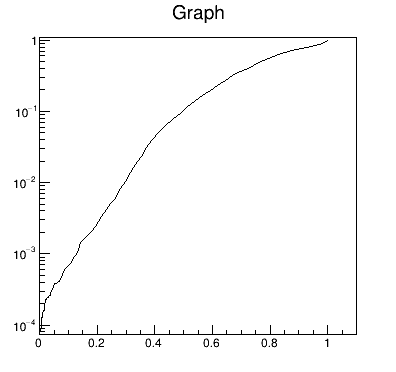

In [10]:
npArray_all_layer_ets = np.array(all_layer_ets)

Xin = torch.from_numpy(np.dstack([npArray_all_layer_ets[:,0], 
    npArray_all_layer_ets[:,1], 
    npArray_all_layer_ets[:,2], 
    npArray_all_layer_ets[:,3],
    npArray_all_layer_ets[:,4]])[0].astype(np.float32)) 

Yout = torch.from_numpy(np.array(all_truth).astype(np.float32).reshape(-1, 1))

print(Yout.shape)
neural_network = torch.nn.Sequential(    # the neural network topology:
    torch.nn.Linear(5, 8),               # input → hidden: 2 dimensions → 5 dimensions
    torch.nn.Sigmoid(),                  # non-linearity applied to each of the 5 components
    torch.nn.Linear(8, 1))               # hidden → output: 5 dimensions → 1 dimension

loss_fn = torch.nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.01)

for i in range(100):                    # iterate 10 times to minimize loss: y_pred - y
    y_pred = neural_network(Xin)           # neural_network is a function: X ↦ y
    loss = loss_fn(y_pred, Yout)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

torch.Size([76861, 1])


In [45]:
# Create data for network-trained ROC curves

# Run all training samples through the trained network
network_outputs = neural_network(Xin)

# Create arrays to hold the number of events left after each Et cut
signal_network_roc_counts = np.zeros(100)
background_network_roc_counts = np.zeros(100)

for i, value in enumerate(network_outputs):
    #total_et = sum(layers)
    if i == 0:
        print(value)
    
    for j in range(100):
        if value > (-0.2 + j*0.01):
            if all_truth[i] == 1:
                signal_network_roc_counts[j] += 1
            elif all_truth[i] == 0:
                background_network_roc_counts[j] += 1
            
# Convert event counts to efficiencies
signal_network_roc_eff = np.array([float(sig_count / signal_network_roc_counts[0]) for sig_count in signal_network_roc_counts])
background_network_roc_eff = np.array([float(back_count / background_network_roc_counts[0]) for back_count in background_network_roc_counts])

tensor([0.4779], grad_fn=<SelectBackward>)


In [43]:
#print(signal_network_roc_eff)
#print(signal_roc_eff)

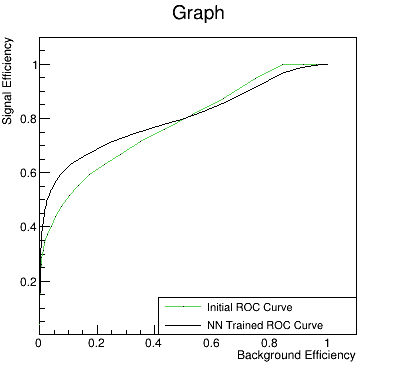

In [46]:
# Plot ROC curves, should make the Y axis linear
roc_curve = ROOT.TGraph(100, background_roc_eff, signal_roc_eff)
network_roc_curve = ROOT.TGraph(100, background_network_roc_eff, signal_network_roc_eff)
c.Clear()
roc_curve.Draw()
roc_curve.SetLineColor(8)
roc_curve.GetXaxis().SetTitle('Background Efficiency')
roc_curve.GetYaxis().SetTitle('Signal Efficiency')

network_roc_curve.Draw('l')
network_roc_curve.SetLineColor(1)

legend = ROOT.TLegend(.4, .1, .9, .2)
legend.AddEntry(roc_curve, 'Initial ROC Curve')
legend.AddEntry(network_roc_curve, 'NN Trained ROC Curve')

legend.Draw()

c.Draw()